In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import sys, os
import math
import scipy.stats
from tqdm import tqdm
import pingouin as pg

sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set(style="whitegrid")
num_agents = 100

In [2]:
# reset
# print('Current directory: ', os.getcwd())
DATA_DIR = os.getcwd()+'/data'
MAP_DIR = os.getcwd()+'/map'
RES_DIR  = os.getcwd()+'/plots'
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [3]:
df_game = pd.read_csv(f'{DATA_DIR}/df_game.csv')
num_episode = np.amax(df_game['episode'].unique())
df_game = df_game[df_game['episode']!=0] #not taking into account the practice session (episode=0)
df_game=df_game.fillna('')
df_game = df_game.reset_index(drop=True)
NUM_EPISODE = df_game['episode'].nunique()

# #Only consider: Easy and Medium level (not consider Hard)
df_game = df_game.loc[df_game['condition']<5]
df_game.tail(3)


,Unnamed: 0,userid,id,condition,episode,target,target_pos,num_step,time_spent,trajectory,created_at
120516,294,A1JWKT0IS06YKL,214610,3,8,green_victim,"8,47",13,00:48,"(4,40);(4,41);(4,42);(4,43);(4,44);(4,45);(4,4...",2021-02-03 13:08:44
120517,294,A1JWKT0IS06YKL,214611,3,8,,,50,00:30,"(8,47);(9,47);(10,47);(11,47);(11,48);(10,48);...",2021-02-03 13:09:02
120518,294,A1JWKT0IS06YKL,214612,3,8,,,86,stop,"(9,38);(10,38);(11,38);(12,38);(13,38);(14,38)...",2021-02-03 13:09:32


### Map Information

In [4]:
map_info = {}
levels = ['simple','complex']
for level in levels:
    map_info[level] = pd.read_csv(f'{MAP_DIR}/map_{level}.csv')

considered_map = levels[1] #medium
print("width: ",max(map_info[considered_map]['x']))
print("height: ",max(map_info[considered_map]['z']))
map_info[considered_map]['key'].unique()
MAX_WIDTH = max(map_info[considered_map]['x'])
MAX_HEIGHT = max(map_info[considered_map]['z'])
TOTAL_GREEN = map_info[considered_map].loc[(map_info[considered_map]['key']=='green victims'),].shape[0]
TOTAL_YELLOW = map_info[considered_map].loc[(map_info[considered_map]['key']=='yellow victims'),].shape[0]
print('# greens: ',TOTAL_GREEN)
print('# yellows: ', TOTAL_YELLOW)

width:  92
height:  49
# greens:  24
# yellows:  10


### Descriptive Analysis
The total number of participants for each condition.

In [5]:
print('Total number of participant:',df_game['userid'].unique().shape[0])
df_game.groupby(['condition'])['userid'].nunique()

Total number of participant: 195


condition
1    48
2    51
3    49
4    47
Name: userid, dtype: int64

In [6]:
# conditions = {0:'easyfov', 1:'easymap', 2:'mediumfov', 3:'mediummap', 4:'hardfov',5:'hardmap'}
# #Keyword mapping regarding Structural Complexity: EASY -> SIMPLE; MEDIUM -> COMPLEX 
conditions = {0:'simplefov', 1:'simplemap', 2:'complexfov', 3:'complexmap'}
total_victims = 34 #CHECK
conditions

{0: 'simplefov', 1: 'simplemap', 2: 'complexfov', 3: 'complexmap'}

In [7]:
orig_conditions = {0:'easyfov', 1:'easymap', 2:'mediumfov', 3:'mediummap'}
# Compute users' average age; female.
df_user = pd.read_csv(f'{DATA_DIR}/QUALTRICS_Pre_Minimap.csv')
df_user = df_user.iloc[2:]
df_user = df_user[['workerId','sessionID','Age','Gender']]

df_user = df_user.loc[(df_user['workerId'].isna()==False) &(df_user['workerId'].duplicated()==False) & (df_user['sessionID'].isin(list(orig_conditions.values()))==True)]
df_user = df_user.rename(columns={'workerId':'userid', 'sessionID':'sessionid','Age':'age','Gender':'gender'})

tmp = pd.DataFrame(list(df_game['userid'].unique()),columns=['userid'])
print(tmp['userid'].isin(df_user['userid']).value_counts())

df_user = pd.merge(tmp['userid'], df_user, on='userid')
# df_user = pd.merge(tmp[['userid']], df_user, right_on='userid', left_on='userid',  how='left')

print(tmp['userid'].isin(df_user['userid']).value_counts())

for c in list(orig_conditions.values()):
    tmp = df_user.loc[df_user['sessionid']==c]['age'].values
    tmp = [int(i) for i in tmp]
    # print(len(tmp))
    print(c)
    # tmp = np.array(tmp)
    print(f"Mean age: {np.mean(tmp)} | STD age: {np.std(tmp)}")
    # print("STD age: \t", c, np.std(tmp))

df_user.groupby(['sessionid','gender'])['userid'].count()

True    195
Name: userid, dtype: int64
True    195
Name: userid, dtype: int64
easyfov
Mean age: 39.5 | STD age: 10.037429949942366
easymap
Mean age: 37.98 | STD age: 10.03093216007366
mediumfov
Mean age: 41.857142857142854 | STD age: 11.349728037737831
mediummap
Mean age: 38.291666666666664 | STD age: 10.912451476282596


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


sessionid  gender
easyfov    Female    25
           Male      23
easymap    Female    22
           Male      28
mediumfov  Female    22
           Male      27
mediummap  Female    23
           Male      25
Name: userid, dtype: int64

In [8]:
# get each condition
data_per_cond = {}
mysum = 0
for i in range(0,len(conditions)):
    data_per_cond[(i)] = df_game.groupby('condition')['userid'].unique()[i:(i+1)].tolist()[0]

In [9]:
data_per_visibility = {}
visibility_name = {0:'FoV',1:'Map'}
for k in visibility_name:
    data_per_visibility[k] = {}
    data_per_visibility[k]={}
    
for i in range(0,len(conditions)):
    if i%2==0:
        k = 0
    else:
        k = 1
    if len(data_per_visibility[k])==0:
        data_per_visibility[k]= df_game.groupby('condition')['userid'].unique()[i:(i+1)].tolist()[0]
    else:
        data_per_visibility[k]= np.concatenate((data_per_visibility[(k)], df_game.groupby('condition')['userid'].unique()[i:(i+1)].tolist()[0]))

In [10]:
data_per_complexity = {}
complexity_levels = {0:'Simple', 1:'Complex'}
for k in complexity_levels:
    data_per_complexity[k] = {}
    data_per_complexity[k] = {}
for i in range(0,len(conditions)):
    if i==0 or i==1:
        k = 0
    elif i==2 or i==3:
        k = 1
    else:
        k = 2
    if len(data_per_complexity[k])==0:
        data_per_complexity[k]= df_game.groupby('condition')['userid'].unique()[i:(i+1)].tolist()[0]
    else:
        data_per_complexity[k]= np.concatenate((data_per_complexity[(k)], df_game.groupby('condition')['userid'].unique()[i:(i+1)].tolist()[0]))


In [11]:
def get_conf_interval(num_observations, alpha=0.05):
    n = num_observations
    return scipy.stats.t.ppf(1 - alpha / 2, n  - 1)
                                                                                         
# get_conf_interval(100)


### Analysis 1: Avg. percent of rescued victims in an episode under each condition
Total of victims in all maps is 34. The value ranges from 0 (zero victims are saved) and 100 (all the victims are saved).


In [12]:
def get_number_saved_victims(data, uid):
    greens = np.zeros(NUM_EPISODE) 
    yellows = np.zeros(NUM_EPISODE)
    # list of green_victims can have redundant, should count only the position of the victim
    for i in range(NUM_EPISODE):
        greens[i] = data.loc[(data['target']=='green_victim') & (data['episode']==(i+1)) & (data['userid']==uid),['episode','target_pos']].nunique()[1]
        yellows[i] = data.loc[(data['target']=='yellow_victim') & (data['episode']==(i+1)) & (data['userid']==uid),['episode','target_pos']].nunique()[1]    
    return (greens,yellows, greens+yellows)

In [13]:
conditions = {0:'simplefov', 1:'simplemap', 2:'complexfov', 3:'complexmap'}

In [14]:
res = {}
green_per_cond = {}
yellow_per_cond = {}
total_per_cond = {}
point_per_cond = {}
ci = {}
for i in tqdm(range(0,len(conditions))):
    # res[i] = np.stack([get_number_saved_victims(df_game, user) for user in data_per_cond[(i)]])
    yellow_per_cond[(i)] = np.stack([get_number_saved_victims(df_game, user)[1]/TOTAL_YELLOW for user in data_per_cond[(i)]])
    total_per_cond [(i)] =  np.stack([get_number_saved_victims(df_game, user)[2]/(TOTAL_GREEN+TOTAL_YELLOW) for user in data_per_cond[(i)]])
    ci[(i)] = np.std(total_per_cond[(i)]) / np.sqrt(total_per_cond [(i)].shape[0]) * get_conf_interval(total_per_cond [(i)].shape[0])                           

100%|██████████| 4/4 [01:09<00:00, 17.28s/it]


In [15]:
# Data for plotting
df = pd.DataFrame(list(zip(list(conditions.values()), [np.mean(total_per_cond[c]) for c in range(0,len(conditions))], [np.mean(ci[c]) for c in range(0,len(conditions))])), columns =['conditions', 'percent_victims', 'ci'])
df

,conditions,percent_victims,ci
0,simplefov,0.432904,0.061368
1,simplemap,0.583117,0.068783
2,complexfov,0.354967,0.064317
3,complexmap,0.534731,0.073481


In [16]:
def draw_plot_all_cond(data_dict, ylabel, output_name):
    plt.rcParams["figure.figsize"] = (7,4)
    conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
    data = []
    for i in range(0,len(conditions)):
        data = data + [list(conditions.values())[i]]*data_dict[i].shape[0]
    data2 = np.concatenate([data_dict[i] for i in range(0,len(conditions))])
    df2 = pd.DataFrame(list(zip(data, data2)), columns =['conditions', 'percent'])
    df2 = pd.DataFrame(data2)
    df2['condition']= data
    df2['percent'] = df2.mean(axis=1)
    ax = sns.violinplot(x=df2["condition"], y=df2["percent"], palette=sns.color_palette("Paired")[2:], data=df2)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    plt.savefig(f"{RES_DIR}/{output_name}.png", bbox_inches='tight')
    return df2

def draw_plot_all_cond_2(data_dict, conditions, ylabel, output_name, *argv):
    plt.rcParams["figure.figsize"] = (7,4)
    my_colors = None
    if len(argv)==0:
        my_colors = sns.color_palette("Paired")[0:]
    else:
        my_colors = argv[0]
    data = []
    for i in range(0,len(conditions)):
        data = data + [list(conditions.values())[i]]*data_dict[i].shape[0]
    data2 = np.concatenate([data_dict[i] for i in range(0,len(conditions))])
    df2 = pd.DataFrame(list(zip(data, data2)), columns =['conditions', 'percent'])
    df2 = pd.DataFrame(data2)
    df2['condition']= data
    df2['percent'] = df2.mean(axis=1)
    ax = sns.violinplot(x=df2["condition"], y=df2["percent"], palette=my_colors, data=df2)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    # ax.set_ylim(top=1)
    plt.savefig(f"{RES_DIR}/{output_name}.png", bbox_inches='tight')
    return df2

def draw_plot_over_time(data_dict, ylabel, conditions, output_name, *argv):    
    plt.rcParams["figure.figsize"] = (7,4)
    
    my_markers = ['x','X','v','^','d','D']
    y= {}
    std = {}
    my_colors = None
    legend_position = 0
    ymax = 0.7
    ymin = 0
    if len(argv)==0:
        my_colors = sns.color_palette("Paired")[2:]
    else:
        my_colors = argv[0]
    if len(argv)==2:
        legend_position = argv[1]
    if len(argv)==3:
        ymax = argv[2][1]
        ymin = argv[2][0]
        print("Ymax", ymax)

    for c in conditions:
        x = list(range(1,NUM_EPISODE+1))
        y[(c)] = np.mean(data_dict[c],0)
        std[(c)] =  np.std(data_dict[c])
        # print('Std', std[(c)])
        num_samples = len(data_dict[c])
        lower_bound = (np.array(y[(c)])-get_conf_interval(num_samples)*std[c]/np.sqrt(num_samples)).flatten()
        # print("Lower", -get_conf_interval(num_samples)*std[c])
        upper_bound = (np.array(y[(c)])+get_conf_interval(num_samples)*std[c]/np.sqrt(num_samples)).flatten()
        # print(upper_bound)
        plt.plot(x, y[(c)], color=my_colors[c], marker= my_markers[c], markersize=8, linestyle='-', linewidth=2, label=conditions[(c)])
        plt.fill_between(x, lower_bound, upper_bound, facecolor=my_colors[c], alpha=0.2)
        # plt.ylim(0,0.7)
        plt.ylim(ymin,ymax)
        plt.xlabel('Episode')
        plt.ylabel(ylabel)
        plt.legend(loc=legend_position, prop={'size': 9})
        plt.grid(True)
        plt.savefig(f"{RES_DIR}/{output_name}.png", bbox_inches='tight')

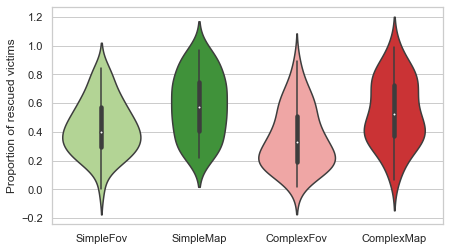

In [17]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
df_melt = draw_plot_all_cond_2(total_per_cond, full_conditions, 'Proportion of rescued victims', 'avg_performance',sns.color_palette("Paired")[2:])

In [18]:
df_melt['uncertainty'] = [i[-3:] for i in df_melt['condition']]
df_melt['complexity'] = [i[:-3] for i in df_melt['condition']]
print(df_melt.shape)

d1 = np.array(list(df_melt.loc[df_melt['complexity']=='Simple','percent']))
d2 = np.array(list(df_melt.loc[df_melt['complexity']=='Complex','percent']))
stat, p = scipy.stats.kruskal(d1, d2)
print(stat,p)

(195, 12)
4.4863797337730364 0.03416595746625632


In [19]:
df_melt.to_csv(f'{DATA_DIR}/clean_data_performance.csv')
df_melt.head()

,0,1,2,3,4,5,6,7,condition,percent,uncertainty,complexity
0,0.529412,0.588235,0.617647,0.617647,0.794118,0.794118,0.852941,0.735294,SimpleFov,0.691176,Fov,Simple
1,0.470588,0.558824,0.676471,0.705882,0.558824,0.705882,0.705882,0.735294,SimpleFov,0.639706,Fov,Simple
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,SimpleFov,0.000000,Fov,Simple
3,0.529412,0.500000,0.500000,0.441176,0.352941,0.470588,0.470588,0.558824,SimpleFov,0.477941,Fov,Simple
4,0.323529,0.323529,0.294118,0.470588,0.264706,0.411765,0.470588,0.441176,SimpleFov,0.375000,Fov,Simple


In [20]:
# statistics 2-way ANOVA
print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3))
print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3).to_latex())

                     Source     SS     DF     MS       F  p-unc    np2
0               uncertainty  1.323    1.0  1.323  29.130  0.000  0.132
1                complexity  0.194    1.0  0.194   4.271  0.040  0.022
2  uncertainty * complexity  0.011    1.0  0.011   0.234  0.629  0.001
3                  Residual  8.672  191.0  0.045     NaN    NaN    NaN
\begin{tabular}{llrrrrrr}
\toprule
{} &                    Source &     SS &     DF &     MS &       F &  p-unc &    np2 \\
\midrule
0 &               uncertainty &  1.323 &    1.0 &  1.323 &  29.130 &  0.000 &  0.132 \\
1 &                complexity &  0.194 &    1.0 &  0.194 &   4.271 &  0.040 &  0.022 \\
2 &  uncertainty * complexity &  0.011 &    1.0 &  0.011 &   0.234 &  0.629 &  0.001 \\
3 &                  Residual &  8.672 &  191.0 &  0.045 &     NaN &    NaN &    NaN \\
\bottomrule
\end{tabular}



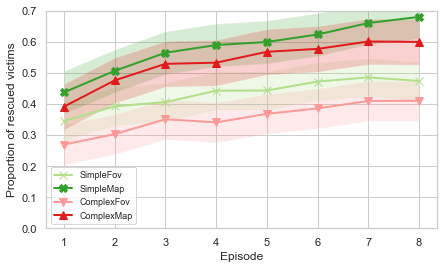

In [21]:
conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
draw_plot_over_time(total_per_cond,'Proportion of rescued victims', conditions, 'time_performance')

### Analysis 2: Effectiveness 
#### Avg. proportion of rescued victims in an episode with FoV and Map (Visibility)

In [22]:
visibility = {}
visibility_yellow = {}
visibility_name = {0:'FoV',1:'Map'}
my_colors = [sns.color_palette('Paired')[6], sns.color_palette('Paired')[7]] 
for k in visibility_name:
    visibility[k] = {}
    visibility_yellow[k]={}
for i in range(0,len(conditions)):
    if i%2==0:
        k = 0
    else:
        k = 1
    if len(visibility[k])==0:
        visibility[k]= np.stack(total_per_cond[(i)])
        visibility_yellow[k]= np.stack(yellow_per_cond[(i)])
    else:
        visibility[k]= np.vstack((visibility[(k)], np.stack(total_per_cond[(i)])))
        visibility_yellow[k]= np.vstack((visibility_yellow[(k)], np.stack(yellow_per_cond[(i)])))

In [23]:
def clean_data (data_dict, conditions, my_variable):
    df = pd.DataFrame({my_variable:list(conditions.values()), 
                   'percent':[np.mean(np.mean(pd.DataFrame(data_dict[(c)]))) for c in conditions],
                  'ci':[np.std(data_dict[(c)]) / np.sqrt(data_dict[(c)].shape[0]) * get_conf_interval(data_dict[(c)].shape[0]) \
                      for c in conditions]})
    return df

def perform_mixed_ANOVA (my_df):
    my_df.insert (0, "id", list(my_df.index+1)) 
    # plt.figure()
    df_melt = pd.melt(my_df.reset_index(), id_vars=['id','condition', 'percent'], value_vars=list(range(8)))
    df_melt.rename(columns={"variable": "episode", "value": "episode_percent"}, inplace=True)
    # ax = sns.boxplot(x='episode', y='episode_percent', hue='condition', data=df_melt)
    df_melt['episode_percent'] = df_melt['episode_percent'].fillna(0)
    res = pg.mixed_anova(dv='episode_percent', between='condition', within='episode', subject='id', correction=False, data=df_melt).round(3)
    return res
    

In [24]:
df = clean_data(visibility, visibility_name,'visibility')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,10.795,1,193,10.795,29.342,0.0,0.132,NaN
1,episode,5.245,7,1351,0.749,102.509,0.0,0.347,0.729
2,Interaction,0.267,7,1351,0.038,5.222,0.0,0.026,NaN


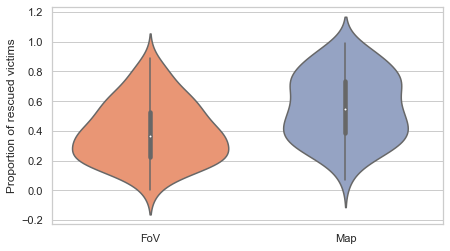

In [25]:
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
df3 = draw_plot_all_cond_2(visibility,visibility_name,'Proportion of rescued victims','vis_avg_performance', my_colors)
perform_mixed_ANOVA(df3)

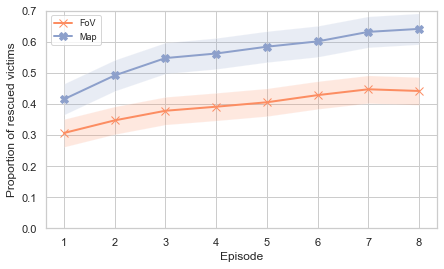

In [26]:
# Visibility effect over time
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
draw_plot_over_time(visibility,'Proportion of rescued victims', visibility_name, 'time_vis_performance', my_colors)

#### Avg. percent of rescued victims with Simple (Easy) & Complex (Medium) maps (Structural Complexity)

In [27]:
complexity = {}
# complexity_levels = {0:'Easy', 1:'Medium', 2:'Hard'}
complexity_levels = {0:'Simple', 1:'Complex'}
complexity_yellow = {}
my_colors = [sns.color_palette('Paired')[0], sns.color_palette('Paired')[1]] 
for k in complexity_levels:
    complexity[k] = {}
    complexity_yellow[k] = {}
for i in range(0,len(conditions)):
    if i==0 or i==1:
        k = 0
    elif i==2 or i==3:
        k = 1
    else:
        k = 2
    if len(complexity[k])==0:
        complexity[k]= np.stack(total_per_cond[(i)])
        complexity_yellow[k]= np.stack(yellow_per_cond[(i)])
    else:
        complexity[k]= np.vstack((complexity[(k)], np.stack(total_per_cond[(i)])))
        complexity_yellow[k]= np.vstack((complexity_yellow[(k)], np.stack(yellow_per_cond[(i)])))

In [28]:
df=clean_data(complexity, complexity_levels, 'complexity')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,1.767,1,193,1.767,4.260,0.040,0.022,NaN
1,episode,5.245,7,1351,0.749,100.209,0.000,0.342,0.729
2,Interaction,0.041,7,1351,0.006,0.774,0.609,0.004,NaN


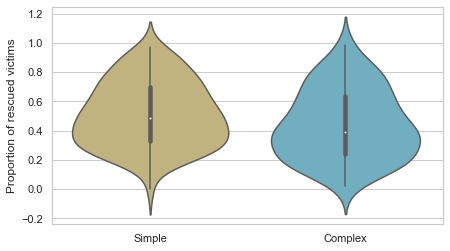

In [29]:
# #Get data for the mixed ANOVA
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
df3 = draw_plot_all_cond_2(complexity,complexity_levels,'Proportion of rescued victims','com_avg_performance', my_colors)
perform_mixed_ANOVA(df3)

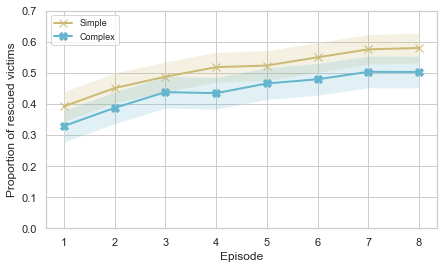

In [30]:
'''2 is upper left'''
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
draw_plot_over_time(complexity,'Proportion of rescued victims', complexity_levels, 'time_com_performance', my_colors, 2)

### Analysis 3: Efficiency
Efficiency = ratio between earned points and the number of steps taken to rescue the last victims

In [31]:
def efficiency_per_uid(uid):
    efficiency = {}
    points = get_number_saved_victims(df_game,uid)[0]*10+get_number_saved_victims(df_game,uid)[1]*30
    for e in range(NUM_EPISODE):
        green = np.array(df_game.loc[(df_game['target']=='green_victim') & (df_game['episode']==e+1) & (df_game['userid']==uid),'num_step'].index)
        yellow = np.array(df_game.loc[(df_game['target']=='yellow_victim') & (df_game['episode']==e+1) & (df_game['userid']==uid),'num_step'].index)
        c = np.concatenate((green,yellow))
        c = sorted(c)
        if len(green)==0 and len(yellow)==0:
            efficiency[e] = 0
        else:
            start = df_game.loc[(df_game['time_spent']=='start') & (df_game['episode']==e+1) & (df_game['userid']==uid),:].index[0]
            end = c[-1]
            denominator = sum(df_game.loc[start:(end+1),'num_step'].values)
            # print(denominator)
            efficiency[e] = points[e]/denominator
    return np.asarray(list(efficiency.values()))

In [32]:
efficiency = {}
for c in tqdm(range(0,len(conditions))):
    efficiency[c] = np.asarray([efficiency_per_uid(a) for a in data_per_cond[(c)]])

100%|██████████| 4/4 [01:57<00:00, 29.38s/it]


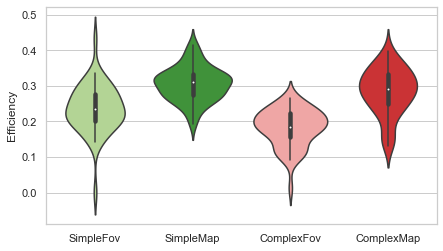

In [33]:
# draw_plot_all_cond(efficiency,ylabel='Efficiency',output_name='avg_efficiency.png')
df_melt = draw_plot_all_cond_2(efficiency, full_conditions, 'Efficiency', 'avg_efficiency',sns.color_palette("Paired")[2:])

In [34]:
df_melt['uncertainty'] = [i[-3:] for i in df_melt['condition']]
df_melt['complexity'] = [i[:-3] for i in df_melt['condition']]
df_melt.head()

print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3))
print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3).to_latex())

                     Source     SS     DF     MS        F  p-unc    np2
0               uncertainty  0.353    1.0  0.353  104.096   0.00  0.353
1                complexity  0.069    1.0  0.069   20.359   0.00  0.096
2  uncertainty * complexity  0.012    1.0  0.012    3.567   0.06  0.018
3                  Residual  0.648  191.0  0.003      NaN    NaN    NaN
\begin{tabular}{llrrrrrr}
\toprule
{} &                    Source &     SS &     DF &     MS &        F &  p-unc &    np2 \\
\midrule
0 &               uncertainty &  0.353 &    1.0 &  0.353 &  104.096 &   0.00 &  0.353 \\
1 &                complexity &  0.069 &    1.0 &  0.069 &   20.359 &   0.00 &  0.096 \\
2 &  uncertainty * complexity &  0.012 &    1.0 &  0.012 &    3.567 &   0.06 &  0.018 \\
3 &                  Residual &  0.648 &  191.0 &  0.003 &      NaN &    NaN &    NaN \\
\bottomrule
\end{tabular}



In [35]:
df_melt.to_csv(f'{DATA_DIR}/clean_data_efficiency.csv')

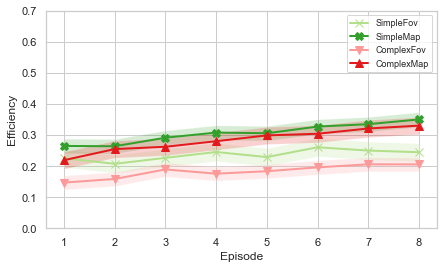

In [36]:
# draw_plot_over_time(total_per_cond,'Proportion of rescued victims', conditions, 'time_performance')
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
draw_plot_over_time(efficiency,'Efficiency', full_conditions, 'efficiency_over_time', sns.color_palette('Paired')[2:])

In [37]:
# Efficiency per visibility
efficiency_vis = {}
for c in tqdm(range(0,len(visibility_name))):
    efficiency_vis[c] = np.asarray([efficiency_per_uid(a) for a in data_per_visibility[(c)]])

100%|██████████| 2/2 [01:56<00:00, 58.15s/it]


\begin{tabular}{llrrrrrrrr}
\toprule
{} &       Source &     SS &  DF1 &   DF2 &     MS &       F &  p-unc &    np2 &    eps \\
\midrule
0 &    condition &  2.893 &    1 &   193 &  2.893 &  95.665 &  0.000 &  0.331 &    NaN \\
1 &      episode &  0.879 &    7 &  1351 &  0.126 &  27.576 &  0.000 &  0.125 &  0.845 \\
2 &  Interaction &  0.117 &    7 &  1351 &  0.017 &   3.684 &  0.001 &  0.019 &    NaN \\
\bottomrule
\end{tabular}



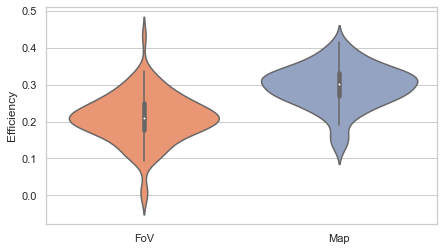

In [38]:
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
df3 = draw_plot_all_cond_2(efficiency_vis,visibility_name, 'Efficiency','vis_efficiency', my_colors)
# perform_mixed_ANOVA(df3)
print(perform_mixed_ANOVA(df3).to_latex())

Ymax 0.4


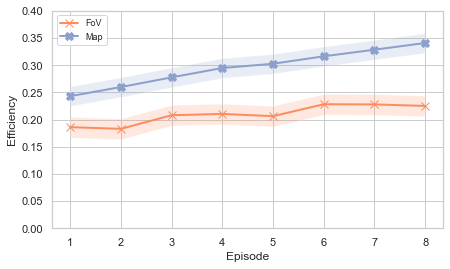

In [39]:
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
draw_plot_over_time(efficiency_vis,'Efficiency', visibility_name, 'vis_efficiency_over_time', my_colors, 0, [0, 0.4])

In [40]:
# #Efficiency per complexity
efficiency_com = {}
for c in tqdm(range(0,len(complexity_levels))):
    efficiency_com[c] = np.asarray([efficiency_per_uid(a) for a in data_per_complexity[(c)]])

100%|██████████| 2/2 [01:56<00:00, 58.46s/it]


\begin{tabular}{llrrrrrrrr}
\toprule
{} &       Source &     SS &  DF1 &   DF2 &     MS &       F &  p-unc &    np2 &    eps \\
\midrule
0 &    condition &  0.619 &    1 &   193 &  0.619 &  14.731 &  0.000 &  0.071 &    NaN \\
1 &      episode &  0.879 &    7 &  1351 &  0.126 &  27.288 &  0.000 &  0.124 &  0.845 \\
2 &  Interaction &  0.052 &    7 &  1351 &  0.007 &   1.629 &  0.123 &  0.008 &    NaN \\
\bottomrule
\end{tabular}



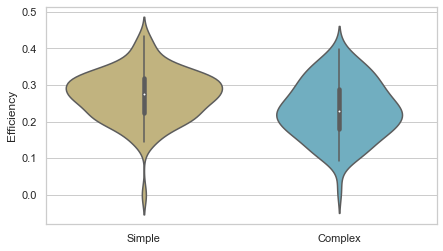

In [41]:
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
df3 = draw_plot_all_cond_2(efficiency_com, complexity_levels, 'Efficiency','com_efficiency', my_colors)
print(perform_mixed_ANOVA(df3).to_latex())

Ymax 0.4


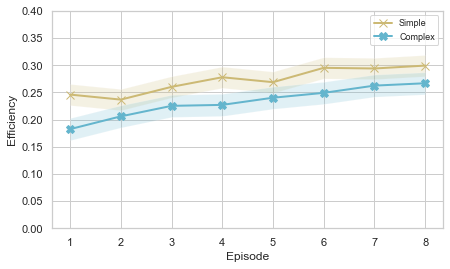

In [42]:
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
draw_plot_over_time(efficiency_com,'Efficiency', complexity_levels, 'com_efficiency_over_time', my_colors, 0, [0, 0.4])

### Analysis 4: Coverage (Trajectory analysis)
Coverage = Total area uniquely explored
        = # (Unique (x,z) squares visited) / # (Total accessible squares)


In [43]:
def coverage_per_uid(uid,df_map):
    coverage = {}
    num_episode = np.max(df_game['episode'].unique())

    num_walls = df_map.loc[df_map["key"]=="walls"].shape[0]
    num_stairs = df_map.loc[df_map["key"]=="stairs"].shape[0]
    num_victims = df_map.loc[df_map["key"]=="green victims"].shape[0] + df_map.loc[df_map["key"]=="yellow victims"].shape[0]
    num_accessible_cells = MAX_WIDTH*MAX_HEIGHT-(num_walls+num_stairs+num_victims)

    for e in range(1,num_episode+1):
        data = df_game.loc[(df_game['episode']==e) & (df_game['userid']==uid),['time_spent','trajectory']]
        data = data.replace(np.nan,'', regex=True)
        res = []
        freq = {}
        for i in range(data.shape[0]):
            row = data.iloc[i,1]
            if not row=='':
                res = res + row.split(';')
        for point in res:
            if point in freq:
                freq[(point)]+=1
            else:
                freq[(point)]=1
        unique_square = len(freq.keys())
        coverage[e] =  unique_square / num_accessible_cells
    return np.asarray(list(coverage.values()))

In [44]:
num_episode = np.max(df_game['episode'].unique())
coverage = {}
for c in tqdm(range(0,len(conditions))):
    if c==0 or c==1:
        df_map = map_info['simple']
    elif c == 2 or c==3:
        df_map = map_info['complex']
    # elif c == 4 or c==5:
    #     df_map = map_info['hard']
    coverage[c] = np.asarray([coverage_per_uid(a, df_map) for a in data_per_cond[(c)]])

100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


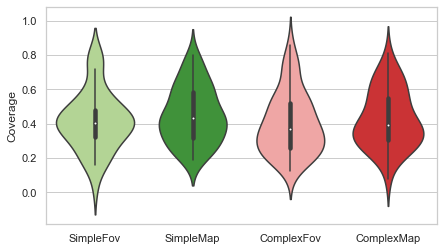

In [45]:
df_melt = draw_plot_all_cond_2(coverage, full_conditions, 'Coverage', 'avg_coverage',sns.color_palette("Paired")[2:])

In [46]:
df_melt['uncertainty'] = [i[-3:] for i in df_melt['condition']]
df_melt['complexity'] = [i[:-3] for i in df_melt['condition']]
df_melt.head()

print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3))
print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3).to_latex())

                     Source     SS     DF     MS      F  p-unc    np2
0               uncertainty  0.043    1.0  0.043  1.474  0.226  0.008
1                complexity  0.019    1.0  0.019  0.645  0.423  0.003
2  uncertainty * complexity  0.001    1.0  0.001  0.027  0.870  0.000
3                  Residual  5.515  191.0  0.029    NaN    NaN    NaN
\begin{tabular}{llrrrrrr}
\toprule
{} &                    Source &     SS &     DF &     MS &      F &  p-unc &    np2 \\
\midrule
0 &               uncertainty &  0.043 &    1.0 &  0.043 &  1.474 &  0.226 &  0.008 \\
1 &                complexity &  0.019 &    1.0 &  0.019 &  0.645 &  0.423 &  0.003 \\
2 &  uncertainty * complexity &  0.001 &    1.0 &  0.001 &  0.027 &  0.870 &  0.000 \\
3 &                  Residual &  5.515 &  191.0 &  0.029 &    NaN &    NaN &    NaN \\
\bottomrule
\end{tabular}



In [47]:
df_melt.to_csv(f'{DATA_DIR}/clean_data_coverage.csv')

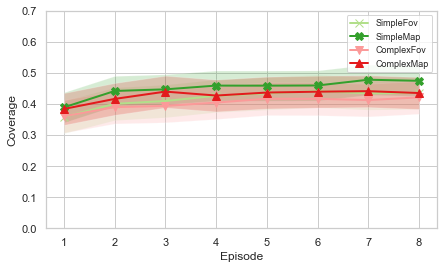

In [48]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
draw_plot_over_time(coverage,'Coverage', full_conditions, 'coverage_over_time', sns.color_palette('Paired')[2:])

In [49]:
# Coverage per visibility (uncertainty)
coverage_vis = {}
for c in tqdm(range(0,len(visibility_name))):
    if c==0 or c==1:
        df_map = map_info['simple']
    elif c == 2 or c==3:
        df_map = map_info['complex']
    coverage_vis[c] = np.asarray([coverage_per_uid(a,df_map) for a in data_per_visibility[(c)]])
    

100%|██████████| 2/2 [00:11<00:00,  5.76s/it]


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,0.352,1,193,0.352,1.538,0.216,0.008,NaN
1,episode,0.742,7,1351,0.106,32.084,0.000,0.143,0.679
2,Interaction,0.018,7,1351,0.003,0.764,0.618,0.004,NaN


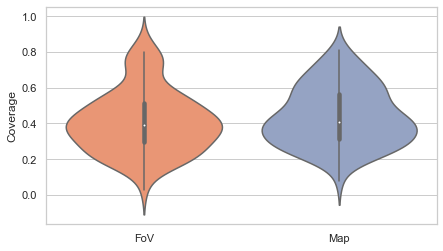

In [50]:
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
df3 = draw_plot_all_cond_2(coverage_vis, visibility_name, 'Coverage', 'vis_coverage',my_colors)
perform_mixed_ANOVA(df3)

In [51]:
# Coverage per complexity (uncertainty)
coverage_com = {}
for c in tqdm(range(0,len(complexity_levels))):
    if c==0 or c==1:
        df_map = map_info['simple']
    elif c == 2 or c==3:
        df_map = map_info['complex']
    coverage_com[c] = np.asarray([coverage_per_uid(a,df_map) for a in data_per_complexity[(c)]])

100%|██████████| 2/2 [00:11<00:00,  5.72s/it]


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,0.176,1,193,0.176,0.767,0.382,0.004,NaN
1,episode,0.742,7,1351,0.106,32.169,0.000,0.143,0.679
2,Interaction,0.029,7,1351,0.004,1.279,0.257,0.007,NaN


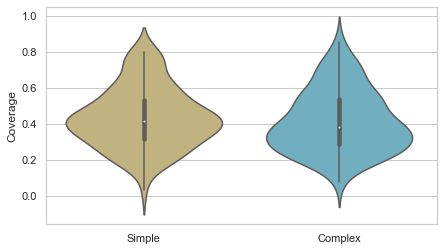

In [52]:
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
df3 = draw_plot_all_cond_2(coverage_com, complexity_levels, 'Coverage','com_coverage', my_colors)
perform_mixed_ANOVA(df3)

### Analysis 5: Redundancy (Trajectory analysis)
Redundancy = Total area non-uniquely explored (visited again)
        = # (excess number of visits to squares) / # (Unique squares visited)

In [53]:
def redundancy_per_uid(uid):
    redundancy = {}
    num_episode = np.max(df_game['episode'].unique())
    for e in range(1,num_episode+1):
        data = df_game.loc[(df_game['episode']==e) & (df_game['userid']==uid),['time_spent','trajectory']]
        data = data.replace(np.nan,'', regex=True)
        res = []
        freq = {}
        unique_visit = 0
        repetitive_visit = 0
        for i in range(data.shape[0]):
            row = data.iloc[i,1]
            if not row=='':
                res = res + row.split(';')
        for point in res:
            if point in freq:
                freq[(point)]+=1
            else:
                freq[(point)]=1
        for k,v in freq.items():
            if v>1:
                repetitive_visit+=1
        if len(freq.keys())==0:
            print(uid, e)
            redundancy[e]=0
        else:
            redundancy[e] = repetitive_visit / len(freq.keys())
    return np.asarray(list(redundancy.values()))

In [54]:
def immediate_redundancy_per_uid(uid):
    redundancy = {}
    num_episode = np.max(df_game['episode'].unique())
    for e in range(1,num_episode+1):
        data = df_game.loc[(df_game['episode']==e) & (df_game['userid']==uid),['time_spent','trajectory']]
        data = data.replace(np.nan,'', regex=True)
        res = []
        freq = {}
        unique_visit = 0
        repetitive_visit = 0
        for i in range(data.shape[0]):
            row = data.iloc[i,1]
            if not row=='':
                res = res + row.split(';')
        for idx, point in enumerate(res):
            if idx+2 < len(res):
                if res[idx] == res[idx+2]:
                    repetitive_visit+=1
            if len(res)==0:
                redundancy[e]=0
            else:
                redundancy[e] = repetitive_visit / len(res)
    return np.asarray(list(redundancy.values()))

In [55]:
num_episode = NUM_EPISODE
redundancy = {}
immediate_redundancy = {}
for c in tqdm(range(0,len(conditions))):
    redundancy[c] = np.asarray([redundancy_per_uid(a) for a in data_per_cond[(c)]])
    immediate_redundancy = np.asarray([immediate_redundancy_per_uid(a) for a in data_per_cond[(c)]])

 25%|██▌       | 1/4 [00:05<00:16,  5.56s/it]

A1Y0Y6U906ABT5 6


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
100%|██████████| 4/4 [00:22<00:00,  5.65s/it]


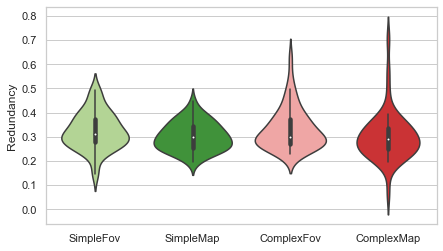

In [56]:
df_melt = draw_plot_all_cond_2(redundancy, full_conditions, 'Redundancy', 'avg_redundancy',sns.color_palette("Paired")[2:])

In [57]:
df_melt['uncertainty'] = [i[-3:] for i in df_melt['condition']]
df_melt['complexity'] = [i[:-3] for i in df_melt['condition']]
df_melt.head()

print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3))
print(df_melt.anova(dv="percent", between=["uncertainty", "complexity"]).round(3).to_latex())

                     Source     SS     DF     MS      F  p-unc    np2
0               uncertainty  0.035    1.0  0.035  5.345  0.022  0.027
1                complexity  0.001    1.0  0.001  0.103  0.749  0.001
2  uncertainty * complexity  0.001    1.0  0.001  0.131  0.717  0.001
3                  Residual  1.242  191.0  0.007    NaN    NaN    NaN
\begin{tabular}{llrrrrrr}
\toprule
{} &                    Source &     SS &     DF &     MS &      F &  p-unc &    np2 \\
\midrule
0 &               uncertainty &  0.035 &    1.0 &  0.035 &  5.345 &  0.022 &  0.027 \\
1 &                complexity &  0.001 &    1.0 &  0.001 &  0.103 &  0.749 &  0.001 \\
2 &  uncertainty * complexity &  0.001 &    1.0 &  0.001 &  0.131 &  0.717 &  0.001 \\
3 &                  Residual &  1.242 &  191.0 &  0.007 &    NaN &    NaN &    NaN \\
\bottomrule
\end{tabular}



In [58]:
df_melt.to_csv(f'{DATA_DIR}/clean_data_redundancy.csv')

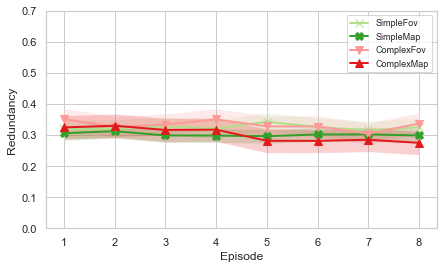

In [59]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
draw_plot_over_time(redundancy,'Redundancy', full_conditions, 'redundancy_over_time', sns.color_palette('Paired')[2:])

In [60]:
# Redundancy per visibility (uncertainty)
redundancy_vis = {}
for c in tqdm(range(0,len(visibility_name))):
    redundancy_vis[c] = np.asarray([redundancy_per_uid(a) for a in data_per_visibility[(c)]])

 50%|█████     | 1/2 [00:05<00:05,  5.48s/it]

A1Y0Y6U906ABT5 6


100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


\begin{tabular}{llrrrrrrrr}
\toprule
{} &       Source &     SS &  DF1 &   DF2 &     MS &      F &  p-unc &    np2 &    eps \\
\midrule
0 &    condition &  0.280 &    1 &   193 &  0.280 &  5.436 &  0.021 &  0.027 &    NaN \\
1 &      episode &  0.088 &    7 &  1351 &  0.013 &  2.010 &  0.051 &  0.010 &  0.564 \\
2 &  Interaction &  0.074 &    7 &  1351 &  0.011 &  1.689 &  0.107 &  0.009 &    NaN \\
\bottomrule
\end{tabular}



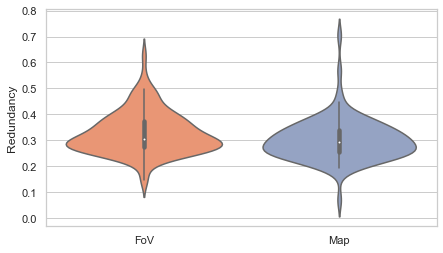

In [61]:
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
df3 = draw_plot_all_cond_2(redundancy_vis, visibility_name, 'Redundancy', 'vis_redundancy',my_colors)
# perform_mixed_ANOVA(df3)
print(perform_mixed_ANOVA(df3).to_latex())

Ymax 0.4


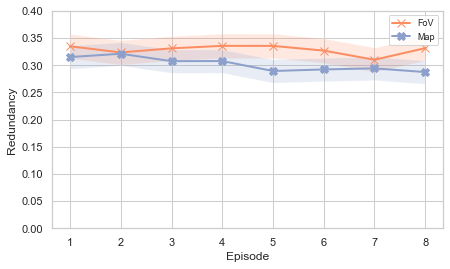

In [62]:
my_colors = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]] 
draw_plot_over_time(redundancy_vis,'Redundancy', visibility_name, 'vis_redundancy_over_time', my_colors, 0, [0, 0.4])

In [63]:
# Redundancy per complexity
redundancy_com = {}
for c in tqdm(range(0,len(complexity_levels))):
    redundancy_com[c] = np.asarray([redundancy_per_uid(a) for a in data_per_complexity[(c)]])

 50%|█████     | 1/2 [00:05<00:05,  5.69s/it]

A1Y0Y6U906ABT5 6


100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,0.008,1,193,0.008,0.142,0.707,0.001,NaN
1,episode,0.088,7,1351,0.013,2.015,0.050,0.010,0.564
2,Interaction,0.094,7,1351,0.013,2.171,0.034,0.011,NaN


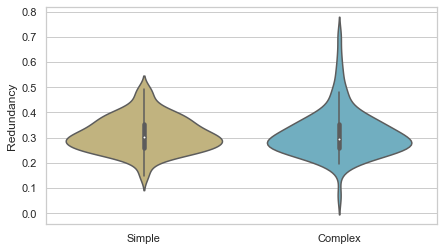

In [64]:
# Perform mixed ANOVA to see if we need to have learning curve across episodes, with regard to efficiency
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
df3 = draw_plot_all_cond_2(redundancy_com, complexity_levels, 'Redundancy','com_redundancy', my_colors)
perform_mixed_ANOVA(df3)

Ymax 0.4


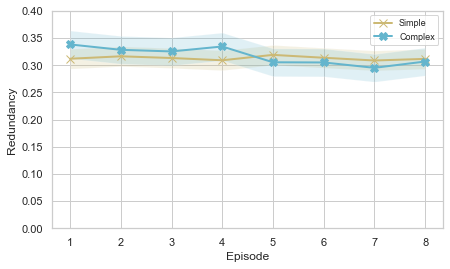

In [65]:
# my_colors =  sns.color_palette('Paired')
my_colors = [sns.color_palette()[8], sns.color_palette()[9]] 
draw_plot_over_time(redundancy_com,'Redundancy', complexity_levels, 'com_redundancy_over_time', my_colors, 0, [0, 0.4])

## Correlation analysis

In [66]:
x = visibility[0]
y = coverage_vis[0].mean(axis=1)
scipy.stats.spearmanr(x, y)
# print(scipy.stats.spearmanr(x, y))


SpearmanrResult(correlation=array([[1.        , 0.8897035 , 0.81271404, 0.82136059, 0.80992148,
        0.82879198, 0.84693938, 0.83608274, 0.8370971 ],
       [0.8897035 , 1.        , 0.81247796, 0.84429374, 0.85082462,
        0.82615974, 0.81996139, 0.84795316, 0.86479254],
       [0.81271404, 0.81247796, 1.        , 0.8164227 , 0.84066659,
        0.83999831, 0.82878553, 0.84600081, 0.88951425],
       [0.82136059, 0.84429374, 0.8164227 , 1.        , 0.86331534,
        0.84739087, 0.83750395, 0.86648775, 0.82965888],
       [0.80992148, 0.85082462, 0.84066659, 0.86331534, 1.        ,
        0.89174418, 0.88136023, 0.87626052, 0.87938079],
       [0.82879198, 0.82615974, 0.83999831, 0.84739087, 0.89174418,
        1.        , 0.88890207, 0.87881184, 0.86558731],
       [0.84693938, 0.81996139, 0.82878553, 0.83750395, 0.88136023,
        0.88890207, 1.        , 0.87140364, 0.84888486],
       [0.83608274, 0.84795316, 0.84600081, 0.86648775, 0.87626052,
        0.87881184, 0.8714036

In [67]:
x2r = np.concatenate((visibility[0], visibility[1])).mean(axis=1)
# x2r = np.concatenate((complexity[0], complexity[1])).mean(axis=1)
y2r = np.concatenate((efficiency_vis[0], efficiency_vis[1])).mean(axis=1)
x3r = np.concatenate((redundancy_vis[0], redundancy_vis[1])).mean(axis=1)
x4r = np.concatenate((coverage_vis[0], coverage_vis[1])).mean(axis=1)
print(scipy.stats.spearmanr(y2r, x3r))

SpearmanrResult(correlation=-0.489758694913334, pvalue=3.69705390250214e-13)


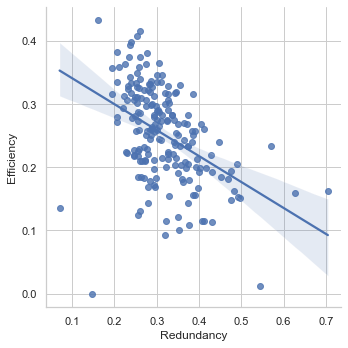

In [68]:
x2r = np.concatenate((redundancy_vis[0], redundancy_vis[1])).mean(axis=1)
y2r = np.concatenate((efficiency_vis[0], efficiency_vis[1])).mean(axis=1)
df_cor = pd.DataFrame({'Redundancy':x2r, 'Efficiency':y2r})
df_cor

ax = sns.lmplot(x="Redundancy", y="Efficiency", data=df_cor)
plt.savefig(f"{RES_DIR}/corr_efficiency_redundancy.png", bbox_inches='tight')


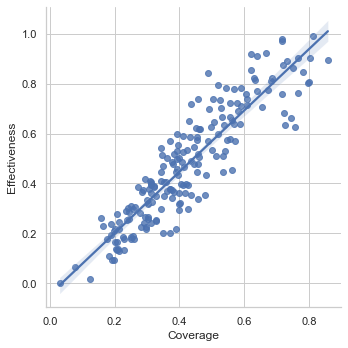

In [69]:

x2r = np.concatenate((coverage_com[0], coverage_com[1])).mean(axis=1)
y2r = np.concatenate((complexity[0], complexity[1])).mean(axis=1)
df_cor = pd.DataFrame({'Coverage':x2r, 'Effectiveness':y2r})
df_cor

ax = sns.lmplot(x="Coverage", y="Effectiveness", data=df_cor)
plt.savefig(f"{RES_DIR}/corr_effectiveness_coverage.png", bbox_inches='tight')

## Box plot with statistical significance information

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator

In [71]:
conditions = {0:'simplefov', 1:'simplemap', 2:'complexfov', 3:'complexmap'}

simple_fov = np.mean(total_per_cond[0],1)
simple_map = np.mean(total_per_cond[1],1)
complex_fov = np.mean(total_per_cond[2],1)
complex_map = np.mean(total_per_cond[3],1)

In [73]:

stat_results = [
  mannwhitneyu(simple_fov, simple_map, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_map, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_map, alternative="two-sided"),
  mannwhitneyu(complex_fov, complex_map, alternative="two-sided"),
]

pvalues = [result.pvalue for result in stat_results]

print("Simple Fov vs Simple Map: \n", stat_results[0], "\n")
print("Simple Fov vs Complex Fov: \n", stat_results[1], "\n")
print("Simple Fov vs Complex Map: \n", stat_results[2], "\n")
print("Simple Map vs Complex Fov: \n", stat_results[3], "\n")
print("Simple Map vs Complex Map: \n", stat_results[4], "\n")
print("Complex Fov vs Complex Map: \n", stat_results[5], "\n")

Simple Fov vs Simple Map: 
 MannwhitneyuResult(statistic=753.5, pvalue=0.000998701582238295) 

Simple Fov vs Complex Fov: 
 MannwhitneyuResult(statistic=1473.0, pvalue=0.032391825606918605) 

Simple Fov vs Complex Map: 
 MannwhitneyuResult(statistic=829.5, pvalue=0.02652761832793169) 

Simple Map vs Complex Fov: 
 MannwhitneyuResult(statistic=1946.5, pvalue=1.5652290242911956e-06) 

Simple Map vs Complex Map: 
 MannwhitneyuResult(statistic=1337.5, pvalue=0.3246568801144697) 

Complex Fov vs Complex Map: 
 MannwhitneyuResult(statistic=637.0, pvalue=0.00016494089309663314) 



In [74]:
pairs = [('Simple-FoV', 'Simple-Map'), 
         ('Simple-FoV', 'Complex-FoV'),
         ('Simple-FoV', 'Complex-Map'),  
         ('Simple-Map', 'Complex-FoV'),  
         ('Simple-Map', 'Complex-Map'),  
         ('Complex-Fov', 'Complex-Map')]

In [75]:
def draw_box_plot_all_cond(data_dict, conditions, ylabel, output_name, *argv):
    plt.rcParams["figure.figsize"] = (7,4)
    my_colors = None
    if len(argv)==0:
        my_colors = sns.color_palette("Paired")[0:]
    else:
        my_colors = argv[0]
    data = []
    for i in range(0,len(conditions)):
        data = data + [list(conditions.values())[i]]*data_dict[i].shape[0]
    data2 = np.concatenate([data_dict[i] for i in range(0,len(conditions))])
    df2 = pd.DataFrame(list(zip(data, data2)), columns =['conditions', 'percent'])
    df2 = pd.DataFrame(data2)
    df2['condition']= data
    df2['percent'] = df2.mean(axis=1)
    ax = sns.boxplot(x=df2["condition"], y=df2["percent"], palette=my_colors, data=df2)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    return df2, ax

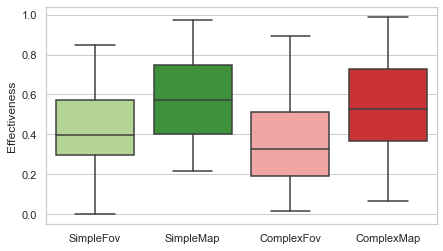

In [76]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
res, ax = draw_box_plot_all_cond(total_per_cond, full_conditions, 'Effectiveness', 'avg_effectiveness', sns.color_palette("Paired")[2:])

In [77]:
pvalues = [result.pvalue for result in stat_results]

formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SimpleFov vs. SimpleMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.992e-03 U_stat=7.535e+02
SimpleMap vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.391e-06 U_stat=1.946e+03
ComplexFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.896e-04 U_stat=6.370e+02
SimpleFov vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.944e-01 U_stat=1.473e+03
SimpleMap vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.338e+03
SimpleFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.592e-01 U_stat=8.295e+02


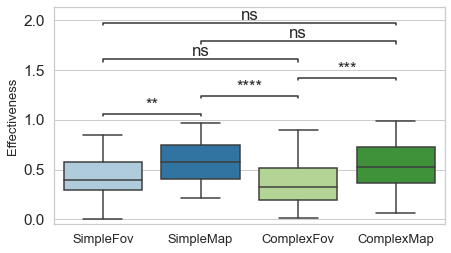

In [78]:
plotting_parameters = {
    'data':    res,
    'x':       'condition',
    'y':       'percent',
    'palette': sns.color_palette("Paired")[0:]
}

pairs = [('SimpleFov', 'SimpleMap'), 
         ('SimpleFov', 'ComplexFov'),
         ('SimpleFov', 'ComplexMap'),  
         ('SimpleMap', 'ComplexFov'),  
         ('SimpleMap', 'ComplexMap'),  
         ('ComplexFov', 'ComplexMap')]


with sns.plotting_context('notebook', font_scale = 1.4):
    figsize = (7, 4)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    sns.boxplot(**plotting_parameters)

    annotator = Annotator(ax, pairs, **plotting_parameters)
    
    annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()
    ax.set_ylabel('Effectiveness', fontsize=13)
    ax.set_xlabel('')
    _, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=13)
    plt.savefig(f"{RES_DIR}/effectiveness-box-plot.png", bbox_inches='tight')
    plt.show()
    

### Efficiency

In [79]:
simple_fov = np.mean(efficiency[0],1)
simple_map = np.mean(efficiency[1],1)
complex_fov = np.mean(efficiency[2],1)
complex_map = np.mean(efficiency[3],1)

In [80]:
stat_results = [
  mannwhitneyu(simple_fov, simple_map, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_map, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_map, alternative="two-sided"),
  mannwhitneyu(complex_fov, complex_map, alternative="two-sided"),
]

pvalues = [result.pvalue for result in stat_results]

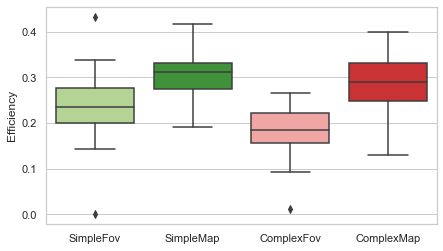

In [81]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
res, ax = draw_box_plot_all_cond(efficiency, full_conditions, 'Efficiency', 'avg_efficiency', sns.color_palette("Paired")[2:])

In [82]:
pvalues = [result.pvalue for result in stat_results]
formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SimpleFov vs. SimpleMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.896e-07 U_stat=4.440e+02
SimpleMap vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.588e-15 U_stat=2.429e+03
ComplexFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.933e-10 U_stat=2.540e+02
SimpleFov vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.391e-04 U_stat=1.763e+03
SimpleMap vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.577e-01 U_stat=1.405e+03
SimpleFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.277e-03 U_stat=6.300e+02


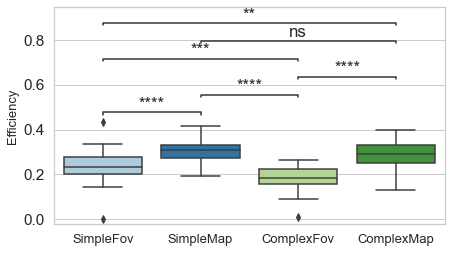

In [83]:
plotting_parameters = {
    'data':    res,
    'x':       'condition',
    'y':       'percent',
    'palette': sns.color_palette("Paired")[0:]
}

pairs = [('SimpleFov', 'SimpleMap'), 
         ('SimpleFov', 'ComplexFov'),
         ('SimpleFov', 'ComplexMap'),  
         ('SimpleMap', 'ComplexFov'),  
         ('SimpleMap', 'ComplexMap'),  
         ('ComplexFov', 'ComplexMap')]


with sns.plotting_context('notebook', font_scale = 1.4):
    figsize = (7, 4)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot with seaborn
    sns.boxplot(**plotting_parameters)

    annotator = Annotator(ax, pairs, **plotting_parameters)
    
    annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()
    ax.set_ylabel('Efficiency', fontsize=13)
    ax.set_xlabel('')
    
    _, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=13)
    plt.savefig(f"{RES_DIR}/efficiency-box-plot.png", bbox_inches='tight')
    plt.show()

### Coverage

In [84]:
simple_fov = np.mean(coverage[0],1)
simple_map = np.mean(coverage[1],1)
complex_fov = np.mean(coverage[2],1)
complex_map = np.mean(coverage[3],1)

In [85]:
stat_results = [
  mannwhitneyu(simple_fov, simple_map, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_map, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_map, alternative="two-sided"),
  mannwhitneyu(complex_fov, complex_map, alternative="two-sided"),
]

pvalues = [result.pvalue for result in stat_results]

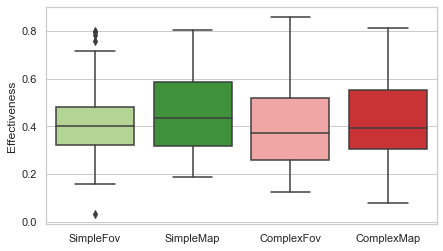

In [86]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
res, ax = draw_box_plot_all_cond(coverage, full_conditions, 'Effectiveness', 'avg_coverage', sns.color_palette("Paired")[2:])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SimpleFov vs. SimpleMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.096e+03
SimpleMap vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.160e-01 U_stat=1.499e+03
ComplexFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.027e+03
SimpleFov vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.281e+03
SimpleMap vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.299e+03
SimpleFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.120e+03


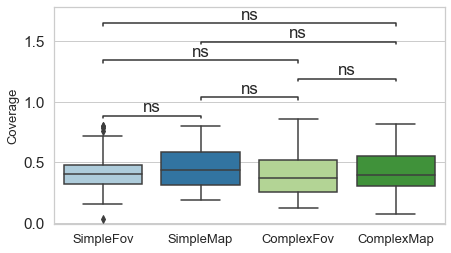

In [87]:
plotting_parameters = {
    'data':    res,
    'x':       'condition',
    'y':       'percent',
    'palette': sns.color_palette("Paired")[0:]
}

pairs = [('SimpleFov', 'SimpleMap'), 
         ('SimpleFov', 'ComplexFov'),
         ('SimpleFov', 'ComplexMap'),  
         ('SimpleMap', 'ComplexFov'),  
         ('SimpleMap', 'ComplexMap'),  
         ('ComplexFov', 'ComplexMap')]


with sns.plotting_context('notebook', font_scale = 1.4):
    figsize = (7, 4)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    sns.boxplot(**plotting_parameters)

    annotator = Annotator(ax, pairs, **plotting_parameters)
    
    annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()
    ax.set_ylabel('Coverage', fontsize=13)
    ax.set_xlabel('')

    _, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=13)
    plt.savefig(f"{RES_DIR}/coverage-box-plot.png", bbox_inches='tight')
    plt.show()

### Redundancy

In [88]:
simple_fov = np.mean(redundancy[0],1)
simple_map = np.mean(redundancy[1],1)
complex_fov = np.mean(redundancy[2],1)
complex_map = np.mean(redundancy[3],1)

In [89]:
stat_results = [
  mannwhitneyu(simple_fov, simple_map, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_fov, complex_map, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_fov, alternative="two-sided"),
  mannwhitneyu(simple_map, complex_map, alternative="two-sided"),
  mannwhitneyu(complex_fov, complex_map, alternative="two-sided"),
]

pvalues = [result.pvalue for result in stat_results]

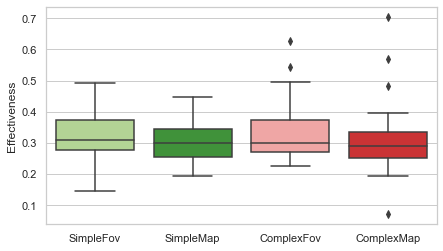

In [90]:
full_conditions = {0:'SimpleFov', 1:'SimpleMap', 2:'ComplexFov', 3:'ComplexMap'}
res, ax = draw_box_plot_all_cond(redundancy, full_conditions, 'Effectiveness', 'avg_redundancy', sns.color_palette("Paired")[2:])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SimpleFov vs. SimpleMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.672e-01 U_stat=1.452e+03
SimpleMap vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.550e-01 U_stat=1.027e+03
ComplexFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.325e-01 U_stat=1.434e+03
SimpleFov vs. ComplexFov: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.189e+03
SimpleMap vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.292e+03
SimpleFov vs. ComplexMap: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.096e-01 U_stat=1.390e+03


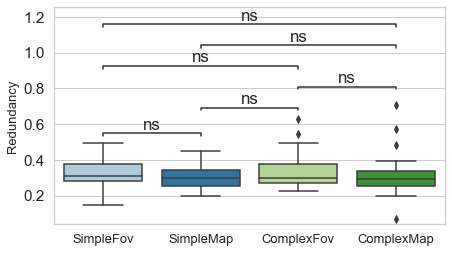

In [91]:
plotting_parameters = {
    'data':    res,
    'x':       'condition',
    'y':       'percent',
    'palette': sns.color_palette("Paired")[0:]
}

pairs = [('SimpleFov', 'SimpleMap'), 
         ('SimpleFov', 'ComplexFov'),
         ('SimpleFov', 'ComplexMap'),  
         ('SimpleMap', 'ComplexFov'),  
         ('SimpleMap', 'ComplexMap'),  
         ('ComplexFov', 'ComplexMap')]


with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    figsize = (7, 4)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    sns.boxplot(**plotting_parameters)
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()
    ax.set_ylabel('Redundancy', fontsize=13)
    ax.set_xlabel('')
    _, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=13)
    plt.savefig(f"{RES_DIR}/redundancy-box-plot.png", bbox_inches='tight')
    plt.show()